In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

In [ ]:
import json
with open("/content/drive/MyDrive/project2_data/train.json",'r') as load_f:
    load_dict = json.load(load_f)
with open("/content/drive/MyDrive/project2_data/test.json",'r') as load_f:
    load_dict_test = json.load(load_f)

# with open("/content/train.json",'r') as load_f:
#     load_dict = json.load(load_f)
# with open("/content/test.json",'r') as load_f:
#     load_dict_test = json.load(load_f)

In [ ]:
#use 80% of it to be the training dataset, rest of it to be validation data
train_len = round(len(load_dict)*0.8)
print('The attribute of data:',load_dict[0].keys())

The attribute of data: dict_keys(['authors', 'year', 'abstract', 'venue', 'title'])


In [ ]:
df = pd.DataFrame(load_dict)
df.head()

authors  year                                           abstract  \
0    [42, 13720, 36]     9  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...   
1  [1359, 15881, 45]    15  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...   
2     [19166, 17763]    17  [40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...   
3               [97]    10  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...   
4         [19617, 2]    10  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...   

  venue                                              title  
0    20  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...  
1     2  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...  
2        [2085, 1719, 1846, 1745, 2243, 1553, 1606, 159...  
3     4  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...  
4     9  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...

In [ ]:
###extract the authors' value & coauthors' value
def co(x):
  x.values[0] = list(filter(lambda i: i>=100, x.values[0]))
  return x
df[['coauthors']] = df[['authors']].apply(lambda x: co(x),axis=1)
len_coauthor = df[['coauthors']].apply(lambda x:len(x.values[0]),axis=1)

def oh(x):
  x.values[0] = list(filter(lambda i: i<100, x.values[0]))
  return x
df[['authors']] = df[['authors']].apply(lambda x: oh(x),axis=1)

df.head()

authors  year                                           abstract venue  \
0  [42, 36]     9  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...    20   
1      [45]    15  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...     2   
2        []    17  [40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...         
3      [97]    10  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...     4   
4       [2]    10  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...     9   

                                               title       coauthors  
0  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...         [13720]  
1  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...   [1359, 15881]  
2  [2085, 1719, 1846, 1745, 2243, 1553, 1606, 159...  [19166, 17763]  
3  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...              []  
4  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...         [19617]

In [ ]:
###delete the paper that do not include any proflic author
pro_author = df.apply(lambda x: len(x[0])!=0, axis=1)
pro_author_index = pro_author[pro_author].index
df_pro_author = df.iloc[pro_author_index]
df_pro_author = pd.concat([df_pro_author,df_pro_author,df_pro_author,df_pro_author,df_pro_author])
df_pro_author = pd.concat([df_pro_author,df_pro_author])
df_pro_author

authors  year                                           abstract  \
0      [42, 36]     9  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...   
1          [45]    15  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...   
3          [97]    10  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...   
4           [2]    10  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...   
9       [44, 2]    18  [1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...   
...         ...   ...                                                ...   
25767      [68]     1  [40, 1542, 1691, 2449, 1535, 2855, 1549, 1755,...   
25776      [67]    10  [40, 1542, 1691, 2907, 1540, 1535, 2121, 2431,...   
25778      [87]    16  [2144, 1661, 2151, 1966, 3776, 4864, 1546, 219...   
25781      [92]    16  [37, 1662, 33, 1814, 2036, 1692, 1553, 2333, 2...   
25788      [78]    14  [46, 1605, 1681, 10, 1557, 4741, 1535, 2021, 1...   

      venue                                              title  \
0        20  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...   
1         2  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...   
3         4  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...   
4         9  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...   
9         0  [1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160...   
...     ...                                                ...   
25767    23  [1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359...   
25776    10  [53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3...   
25778    31  [1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1...   
25781     0  [46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152...   
25788     1  [46, 1910, 36, 2107, 1547, 1553, 1716, 1528, 5...   

                        coauthors  
0                         [13720]  
1                   [1359, 15881]  
3                              []  
4                         [19617]  
9                    [9641, 5623]  
...                           ...  
25767               [19974, 8903]  
25776  [6353, 3037, 15856, 13521]  
25778          [7686, 3810, 7451]  
25781                     [14864]  
25788                      [1797]  

[7460 rows x 6 columns]

In [ ]:
non_author = df.apply(lambda x: len(x[0])==0, axis=1)
non_author_index = non_author[non_author].index

### random select 2000 from non-prolific author
# random.seed(2022)
# non_index_random2000 = random.sample(list(non_author_index), 2000) 
# df_non = df.iloc[non_index_random2000]

#### concat data with 10*prolific with non-prolific
df_non = df.iloc[non_author_index]
df_non['authors'] = 101
df = pd.concat([df_pro_author,df_non])
df = df.reset_index().drop(columns = ['index'])
df_y = df[['authors']]

###one-hot encode for train_y
s = df_y['authors']
y_features = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
y_features = y_features.drop(101, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  


In [ ]:
df_y.shape

(8460, 1)

In [ ]:
y_features

0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   ...  90.0  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     1     0     0     0     0     0     0     0  ...     0   
4        0     0     1     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
8455     0     0     0     0     0     0     0     0     0     0  ...     0   
8456     0     0     0     0     0     0     0     0     0     0  ...     0   
8457     0     0     0     0     0     0     0     0     0     0  ...     0   
8458     0     0     0     0     0     0     0     0     0     0  ...     0   
8459     0     0     0     0     0     0     0     0     0     0  ...     0   

      91.0  92.0  93.0  94.0  95.0  96.0  97.0  98.0  99.0  
0        0     0     0     0     0     0     0     0     0  
1        0     0     0     0     0     0     0     0     0  
2        0     0     0     0     0     0     1     0     0  
3        0     0     0     0     0     0     0     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
8455     0     0     0     0     0     0     0     0     0  
8456     0     0     0     0     0     0     0     0     0  
8457     0     0     0     0     0     0     0     0     0  
8458     0     0     0     0     0     0     0     0     0  
8459     0     0     0     0     0     0     0     0     0  

[8460 rows x 100 columns]

In [ ]:
df['venue'] = df[['venue']].apply(lambda x: x if x.values[0]!='' else 465,axis = 1)

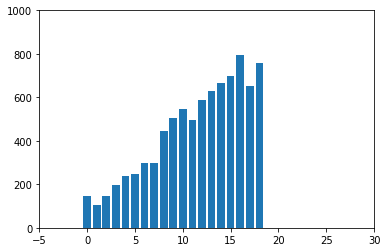

In [ ]:
plt.bar(df['year'].value_counts().index,df['year'].value_counts().values)
plt.xlim([-5,30])
plt.ylim([0,10000])
plt.show()

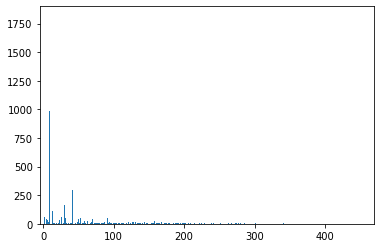

In [ ]:
plt.bar(df['venue'].value_counts().index,df['venue'].value_counts().values)
plt.xlim([-5,470])
plt.ylim([0,19000])
plt.show()

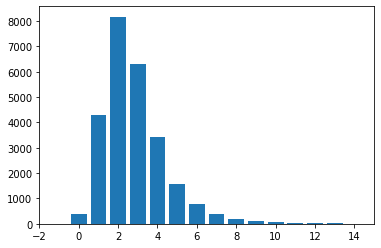

In [ ]:
plt.bar(len_coauthor.value_counts().index,len_coauthor.value_counts().values)
plt.xlim([-2,15])
plt.show()

In [ ]:
print(df.shape,y_features.shape)

(8460, 6) (8460, 100)


In [ ]:
df_x = df[["year","venue", "coauthors", "abstract", "title"]]
df_x.head()

year  venue      coauthors  \
0     9     20        [13720]   
1    15      2  [1359, 15881]   
2    10      4             []   
3    10      9        [19617]   
4    18      0   [9641, 5623]   

                                            abstract  \
0  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...   
1  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...   
2  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...   
3  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...   
4  [1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...   

                                               title  
0  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...  
1  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...  
2  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...  
3  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...  
4  [1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160...

In [ ]:
print(df_x.shape,y_features.shape)

(8460, 5) (8460, 100)


In [ ]:
def co_non(x):
  if len(x.values[0])!=0:
    return x
  else:
    x.values[0] = [21246]
    return x
df_x[['coauthors']] = df_x[['coauthors']].apply(lambda x: co_non(x),axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
df_x.head()

year  venue      coauthors  \
0     9     20        [13720]   
1    15      2  [1359, 15881]   
2    10      4        [21246]   
3    10      9        [19617]   
4    18      0   [9641, 5623]   

                                            abstract  \
0  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...   
1  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...   
2  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...   
3  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...   
4  [1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...   

                                               title  
0  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...  
1  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...  
2  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...  
3  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...  
4  [1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160...

In [ ]:
###split the training dataset to validation dataset and training dataset
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(df_x,y_features,test_size=0.2,random_state=2022)

In [ ]:
def create_dataset(x,y):
  instances = []
  for i in range(x_val.shape[0]):
    instance = []
    instance.append(x.iloc[i,0])
    instance.append(x.iloc[i,1])
    instance.append(torch.tensor(x.iloc[i,2]))
    instance.append(torch.tensor(x.iloc[i,3]))
    instance.append(torch.tensor(x.iloc[i,4]))
    instances.append([np.array(instance),y.iloc[i,:].values])

  return instances

In [ ]:
train = create_dataset(x_train,y_train)
val = create_dataset(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
y_train

0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   ...  90.0  \
1514     0     0     0     0     0     0     0     0     0     0  ...     0   
4128     0     0     0     0     0     0     0     0     0     0  ...     0   
728      0     0     0     0     0     0     0     0     0     0  ...     0   
1851     0     0     0     0     0     0     0     0     0     0  ...     0   
847      1     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
6384     0     0     0     0     0     0     0     0     0     0  ...     0   
4720     0     0     0     0     0     0     0     0     0     0  ...     0   
173      0     0     0     0     0     0     0     0     0     0  ...     0   
1244     0     0     0     0     0     0     0     0     0     0  ...     0   
4989     0     0     1     0     0     0     0     0     0     0  ...     0   

      91.0  92.0  93.0  94.0  95.0  96.0  97.0  98.0  99.0  
1514     0     0     0     0     0     0     0     0     0  
4128     0     0     0     0     0     0     0     0     1  
728      0     0     0     0     0     0     0     0     0  
1851     0     0     0     0     0     0     0     0     0  
847      0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
6384     0     0     0     0     0     0     0     0     0  
4720     0     0     0     0     0     0     0     0     0  
173      0     0     0     0     0     0     0     0     0  
1244     0     0     0     0     0     0     0     0     0  
4989     0     0     0     0     0     0     0     0     0  

[6768 rows x 100 columns]

In [ ]:
def my_collate(data):
  years = []
  venue = []
  coauthors = []
  abstract = []
  title = []

  authors = []
  for paper, label in data:
    
    years.append(paper[0])
    venue.append(paper[1])
    
    coauthors.append(paper[2])
    abstract.append(paper[3])
    title.append(paper[4])
    authors.append(label.astype(int))
  return {'year':torch.tensor([years]),'venue':torch.tensor([venue]),'coauthors':coauthors,'abstract':abstract,'title':title,'author':authors}

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1234) 
batch_size = 128
hidden_dim = 128

train_loader = DataLoader(train, batch_size=batch_size, collate_fn=my_collate, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, collate_fn=my_collate, shuffle=True)

In [ ]:
year_num = 20
venue_num = 467
coauthor_num = 21248
word_num = 5000

# Model Architecture

## One layer Neural Network Architecture

In [ ]:
from traitlets.traitlets import validate
class ANNModel(nn.Module):
    def __init__(self, input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim):
        super(ANNModel, self).__init__()

        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.fc1 = nn.Linear(input_dim, output_dim) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year)#year embedding
        v = self.vembed(venue).view(-1,embed_venue)#venue embedding
        
        co = []#coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = []#coauthor embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = []#coauthor embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)

        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1)
        out = self.fc1(all_embed)
        out = self.sigmoid(out)
        return out

In [ ]:
def trainann(model, optimizer, train_loader, num_epochs,input_dim, criterion):
    train_losses = []
    f1_scores = []
    for epoch in range(num_epochs):
        batch_loss = []  
        for i, item in enumerate(train_loader):
            # adjust the batch size
            labels = torch.tensor(item['author']).float()

            optimizer.zero_grad()
 
            predictions = model(item)
            loss = criterion(predictions, labels)
            loss.backward()

            optimizer.step()
            batch_loss.append(loss.item())


        train_loss = np.mean(batch_loss)
        train_losses.append(train_loss)  
        c = predictions.cpu().detach().numpy()
        pred = np.where(c>0.5,1,0)
        from sklearn.metrics import f1_score
        f1score = f1_score(labels, pred, average='samples', zero_division=1)
        f1_scores.append(f1score)

        if (epoch+1) % 5 == 0:
            print('epoch: {}. Loss: {}. f1_score: {}'.format(epoch+1, train_loss, f1score))

    return train_losses, f1_scores

In [ ]:
embed_year, embed_venue, embed_co, embed_word = 10, 20, 200, 100
num_epochs = 50
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.01
weight_decay = 1e-8 

ann_model1 = ANNModel(input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim)
optimizer = torch.optim.Adam(ann_model1.parameters(), lr=learning_rate, weight_decay=weight_decay) 


anntrain_loss, annf1_score = trainann(ann_model1, optimizer, train_loader, num_epochs, input_dim, criterion)

## Deep ANN Architecture

In [ ]:
import torch.nn.functional as F

HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 256
HIDDEN_DIM3 = 256

class DeepANN(nn.Module):
    
    def __init__(self, input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim, hidden_dim1 = HIDDEN_DIM1, hidden_dim2 = HIDDEN_DIM2, hidden_dim3 = HIDDEN_DIM3):
        super().__init__()
        
        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.sigmoid = nn.Sigmoid()

        self.input_layer = nn.Linear(input_dim, hidden_dim1)
        self.hidden_layer1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.hidden_layer2 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output_layer = nn.Linear(hidden_dim3, output_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year)#year embedding
        #y = year.view(year.size()[1],-1)
        v = self.vembed(venue).view(-1,embed_venue)#venue embedding
        
        co = []#coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = []#abstract embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = []#title embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)
        
        
        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1)
        
        out = F.relu(self.input_layer(all_embed))
        out = self.dropout(out)
                
        out = F.relu(self.hidden_layer1(out))
        out = self.dropout(out) 
        out = F.relu(self.hidden_layer2(out))
        out = self.dropout(out)  

        out = self.output_layer(out)

        # out = self.input_layer(all_embed)
        # out = self.dropout(out)
                
        # out = self.hidden_layer1(out)
        # out = self.dropout(out) 
        # out = self.hidden_layer2(out)
        # out = self.dropout(out)  

        # out = self.output_layer(out)

        #out = self.sigmoid(out)
        return out
        

In [ ]:
def traindeepann(model, optimizer, train_loader, num_epochs,input_dim, criterion):
    train_losses = []
    f1_scores = []
    for epoch in range(num_epochs):
        batch_loss = []  
        for i, item in enumerate(train_loader):
            labels = torch.tensor(item['author']).float()

            optimizer.zero_grad()
 
            predictions = model(item)
            loss = criterion(predictions, labels)
            loss.backward()

            optimizer.step()
            batch_loss.append(loss.item())


        train_loss = np.mean(batch_loss)
        train_losses.append(train_loss)  
        c = predictions.cpu().detach().numpy()
        pred = np.where(c>0.5,1,0)
        from sklearn.metrics import f1_score
        f1score = f1_score(labels, pred, average='samples', zero_division=1)
        f1_scores.append(f1score)

        if (epoch+1) % 5 == 0:
            print('epoch: {}. Loss: {}. f1_score: {}'.format(epoch+1, train_loss, f1score))

    return train_losses, f1_scores

In [ ]:
embed_year, embed_venue, embed_co, embed_word = 10, 50, 200, 100
num_epochs = 50
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.01
weight_decay = 1e-8 

dann_model = DeepANN(input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim)
optimizer = torch.optim.Adam(dann_model.parameters(), lr=learning_rate, weight_decay = weight_decay) 

danntrain_loss, dannf1_score = traindeepann(dann_model, optimizer, train_loader, num_epochs, input_dim, criterion)

##### Validation

In [ ]:
def valid(train_loader, model, criterion):
  with torch.no_grad():
    val_batch_loss = []
    pred = []
    true = []
    for i, item in enumerate(train_loader):
      # adjust the batch size
      labels = torch.tensor(item['author']).float()
      model.eval()

      yhat = model(item)
      val_loss = criterion(yhat, labels)
      val_batch_loss.append(val_loss.item())

      c = yhat.cpu().detach().numpy()
      pred.append(np.where(c>0.5,1,0))
      true.append(labels.cpu().detach().numpy())

    from sklearn.metrics import f1_score
    val_result = np.zeros([128*(len(pred)-1)+pred[-1].shape[0],100])
    val_true = np.zeros([128*(len(true)-1)+true[-1].shape[0],100])
    for i,batch in enumerate(pred):
      for j,value in enumerate(batch):
        val_result[i*128+j,:]=pred[i][j]
        val_true[i*128+j,:]=true[i][j]
    f1score = f1_score(val_result, val_true, average='samples',zero_division=1)

  return f1score

In [ ]:
valid(val_loader, dann_model, criterion)

0.4380755375436226

##### Test

In [ ]:
def test_adjust(test):

  test = pd.DataFrame(test)[['year','venue','coauthors','abstract','title']]
  test['venue'] = test[['venue']].apply(lambda x: x if x.values[0]!='' else 465,axis = 1)
  test[['coauthors']] = test[['coauthors']].apply(lambda x: co_non(x),axis=1)

  years = []
  venue = []
  coauthors = []
  abstract = []
  title = []

  for i in range(test.shape[0]):
    
    years.append(test.iloc[i,0])
    venue.append(test.iloc[i,1])
    
    coauthors.append(torch.tensor(test.iloc[i,2]))
    abstract.append(torch.tensor(test.iloc[i,3]))
    title.append(torch.tensor(test.iloc[i,4]))

  return {'year':torch.tensor([years]),'venue':torch.tensor([venue]),'coauthors':coauthors,'abstract':abstract,'title':title}

In [ ]:
def testsol(test_data, model):
  #get prediction
  with torch.no_grad():
    model.eval()
    yhat_test = model(test_data)
    c_test = yhat_test.cpu().detach().numpy()
    pred_test = np.where(c_test>0.5,1,0)

  #adjust the form of soluton
  pred_list = []
  for i in range(pred_test.shape[0]):
    if(len(np.where(pred_test[i]==1)[0])==0):
      pred_list.append(np.array([-1]))  
    else:
      pred_list.append(np.where(pred_test[i]==1))  

  #output the solution      
  test_result = pd.DataFrame(np.array(pred_list))
  test_result[0] = test_result[0].map(str).apply(lambda x: x.replace('[','').replace(']',''))
  test_result.to_csv('sol.csv')

In [ ]:
test_data = test_adjust(load_dict_test)

In [ ]:
testsol(test_data, dann_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## RNN

In [ ]:
class RNNModel(nn.Module):
    def __init__(self,embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year)#year embedding
        #y = year.view(year.size()[1],-1)
        v = self.vembed(venue).view(-1,embed_venue)#venue embedding
        
        co = []#coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = []#abstract embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = []#title embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)
        
        
        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1).view(-1,1,input_dim)

        h0 = torch.zeros(self.layer_dim, year.size()[1], self.hidden_dim).requires_grad_()

        out, h0 = self.rnn(all_embed, h0.detach())
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [ ]:
def trainrnn(model, optimizer, train_loader, num_epochs,input_dim, criterion):
    train_losses = []
    f1_scores = []
    for epoch in range(num_epochs):
        batch_loss = []  
        for i, item in enumerate(train_loader):
            # adjust the batch size
            labels = torch.tensor(item['author']).float()

            optimizer.zero_grad()
 
            predictions = model(item)
            loss = criterion(predictions, labels)
            loss.backward()

            optimizer.step()
            batch_loss.append(loss.item())

        train_loss = np.mean(batch_loss)
        train_losses.append(train_loss)  
        c = predictions.cpu().detach().numpy()
        pred = np.where(c>0.5,1,0)
        from sklearn.metrics import f1_score
        f1score = f1_score(labels, pred, average='samples', zero_division=1)
        f1_scores.append(f1score)

        if (epoch+1) % 5 == 0:
          print('epoch: {}. Loss: {}. f1_score: {}'.format(epoch+1, train_loss, f1score))

    return train_losses,f1_scores

In [ ]:
embed_year, embed_venue, embed_co, embed_word = 10, 50, 200, 100
num_epochs = 50
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
layer_dim = 3
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005
weight_decay = 1e-8 

rnn_model = RNNModel(embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


rnn_train_loss,rnn_f1_scores = trainrnn(rnn_model, optimizer, train_loader, num_epochs, input_dim, criterion)

In [ ]:
valid(val_loader, rnn_model, criterion)

In [ ]:
testsol(test_data, rnn_model)

## LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self,embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year)#year embedding
        #y = year.view(year.size()[1],-1)
        v = self.vembed(venue).view(-1,embed_venue)#venue embedding
        
        co = []#coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = []#abstract embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = []#title embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)
        
        
        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1).view(-1,1,input_dim)

        h0 = torch.zeros(self.layer_dim, year.size()[1], self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, year.size()[1], self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(all_embed, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [ ]:
embed_year, embed_venue, embed_co, embed_word = 10, 50, 200, 100
num_epochs = 50
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
layer_dim = 3
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005
weight_decay = 1e-8 

lstm_model = LSTMModel(embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


lstm_train_loss,lstm_f1_score = trainrnn(lstm_model, optimizer, train_loader, num_epochs, input_dim, criterion)

epoch: 5. Loss: 4.358747107642038. f1_score: 0.05060410703765413


In [ ]:
valid(val_loader, lstm_model, criterion)

In [ ]:
testsol(test_data, lstm_model)